# Coding a Neural Network (MLP) in pure Numpy, but pytorch style

### This is very similar to 4.1, but here they do multi-class classification (with softmax) and so we can use MNIST


# MLP in pure numpy, but coded pytorch-style

Here we show a nice code (directly taken from this source:)
- http://www.adeveloperdiary.com/data-science/deep-learning/neural-network-with-softmax-in-python/
- https://github.com/adeveloperdiary/blog/blob/master/Backpropagation_Algorithm_using_Softmax/main.py

This code does multi-class classification in pure numpy, following the logic of pytorch.

### We apply it on Mnist, but it could be anything


In [1]:
import numpy as np
# import datasets.mnist.loader as mnist
import matplotlib.pylab as plt
# from sklearn.preprocessing import OneHotEncoder
import sklearn.model_selection
import sklearn.preprocessing._encoders

In [2]:
## we load the whole data set at once, so as to manipulate it directly (using numpy arrays)
## for very large data sets, one needs to read on-the-fly (at least at production time, not at the debugging stage)

data = np.load('/home/flandes/data/mnist70.npz', 'X', 'y')
X = data['X']
y = data['y']
oneHotEncoderInstance = sklearn.preprocessing._encoders.OneHotEncoder(sparse_output=False)  
## sparse=False:  more memory hungry, again, but easier to read when debugging
y = oneHotEncoderInstance.fit_transform(y.reshape(-1,1))
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

In [3]:
X.shape, y.shape

((70000, 784), (70000, 10))

In [4]:
class ANN:
    def __init__(self, layers_size):
        self.layers_size = layers_size
        self.parameters = {}
        self.L = len(self.layers_size)
        self.n = 0
        self.costs = []

    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=0, keepdims=True)

    def initialize_parameters(self):
        np.random.seed(1)

        for l in range(1, len(self.layers_size)):
            self.parameters["W" + str(l)] = np.random.randn(self.layers_size[l], self.layers_size[l - 1]) / np.sqrt(
                self.layers_size[l - 1])
            
            ## biases are initialized to 0
            ## and are of shape D_ell vectors: each neuron gets a bias
            self.parameters["b" + str(l)] = np.zeros((self.layers_size[l], 1))

    def forward(self, X):
        store = {}

        A = X.T #A stands for Activation
        for l in range(self.L - 1):
            # Z = W_l @ A + b_l
            Z = self.parameters["W" + str(l + 1)].dot(A) + self.parameters["b" + str(l + 1)]
            # A = sigma(Z) = sigma(W_l @ A + b_l)
            A = self.sigmoid(Z)
            
            ## we have to store not only the parameters, but also activations !
            store["A" + str(l + 1)] = A
            store["W" + str(l + 1)] = self.parameters["W" + str(l + 1)]
            store["Z" + str(l + 1)] = Z
        # A1 = sigmoid(W1 @ A0 + b1) = sigmoid(Z1)
        # A2 = sigmoid(W2 @ A1 + b2) = sigmoid(Z2)
        # ZL = WL @ A_(L-1) + bL
        # AL = softmax(ZL)
        Z = self.parameters["W" + str(self.L)].dot(A) + self.parameters["b" + str(self.L)]
        A = self.softmax(Z)
        
        ## last activation is a softmax, which is a function of the full vector of Z (size K, the # of classes)
        store["A" + str(self.L)] = A
        store["W" + str(self.L)] = self.parameters["W" + str(self.L)]
        store["Z" + str(self.L)] = Z

        return A, store

    def sigmoid_derivative(self, Z):
        s = 1 / (1 + np.exp(-Z))
        return s * (1 - s)

    def backward(self, X, Y, store):

        derivatives = {}

        store["A0"] = X.T

        A = store["A" + str(self.L)]
        # A_L : represents our \hat{y}
        dZ = A - Y.T  # shape is: (K, N)
        ## derivation of cross-entropy loss gives (y_hat - y).nabla_{parameters}(y_hat)

        # dW = (y_hat -Y).T @ A_{L-1}
        dW = dZ.dot(store["A" + str(self.L - 1)].T) / self.n
        # db : we sum dZ over the axis N (in other words, matmul with an array of ones (N,1))
        db = np.sum(dZ, axis=1, keepdims=True) / self.n
        # dAPrev = before the softmax
        # dAPrev = W_L @ dZ
        dAPrev = store["W" + str(self.L)].T.dot(dZ)
        
        derivatives["dW" + str(self.L)] = dW
        derivatives["db" + str(self.L)] = db

        for l in range(self.L - 1, 0, -1):
            dZ = dAPrev * self.sigmoid_derivative(store["Z" + str(l)])
            dW = 1. / self.n * dZ.dot(store["A" + str(l - 1)].T)
            db = 1. / self.n * np.sum(dZ, axis=1, keepdims=True)
            if l > 1: ## because after this, dAprev is not needed
                dAPrev = store["W" + str(l)].T.dot(dZ)

            derivatives["dW" + str(l)] = dW
            derivatives["db" + str(l)] = db

        return derivatives

    def fit(self, X, Y, learning_rate=0.01, n_iterations=2500):
        np.random.seed(1)

        self.n = X.shape[0]

        self.layers_size.insert(0, X.shape[1])

        self.initialize_parameters()
        for loop in range(n_iterations):
            A, store = self.forward(X)
            cost = -np.mean(Y * np.log(A.T))
            derivatives = self.backward(X, Y, store)

            for l in range(1, self.L + 1):
                self.parameters["W" + str(l)] = self.parameters["W" + str(l)] - learning_rate * derivatives[
                    "dW" + str(l)]
                self.parameters["b" + str(l)] = self.parameters["b" + str(l)] - learning_rate * derivatives[
                    "db" + str(l)]

            if loop % 100 == 0:
                print("Cost: ", cost, "Train Accuracy:", self.predict(X, Y))

            if loop % 10 == 0:
                self.costs.append(cost)

    def predict(self, X, Y):
        A, cache = self.forward(X)
        y_hat = np.argmax(A, axis=0)
        Y = np.argmax(Y, axis=1)
        accuracy = (y_hat == Y).mean()
        return accuracy * 100

    def plot_cost(self):
        plt.figure()
        plt.plot(np.arange(len(self.costs)), self.costs)
        plt.xlabel("epochs")
        plt.ylabel("cost")
        plt.show()


def pre_process_data(train_x, train_y, test_x, test_y):
    # Normalize
    train_x = train_x / 255.
    test_x = test_x / 255.

    enc = OneHotEncoder(sparse=False, categories='auto')
    train_y = enc.fit_transform(train_y.reshape(len(train_y), -1))

    test_y = enc.transform(test_y.reshape(len(test_y), -1))

    return train_x, train_y, test_x, test_y



### To look into the code, you can do a dirty hack, creating an instance and then looking at the values during the backward pass

In [5]:
## dirty hack: call the instance self for less need to ctrl-replace
layers_dims = [50, 10]
n_iterations=1
self = ANN(layers_dims)
self.fit(X_train, y_train, learning_rate=0.03, n_iterations=n_iterations)
A, store = self.forward(X_train)
derivatives = self.backward(X_train, y_train,store)
X, Y = X_train.copy(), y_train.copy()

Cost:  0.24024293748533238 Train Accuracy: 8.818763326226014


In [6]:
# copy-paste of the inside of backward()
derivatives = {}

store["A0"] = X.T

A = store["A" + str(self.L)]
# A_L : represents our \hat{y}
dZ = A - Y.T  # shape is: (K, N)
## derivation of cross-entropy loss gives (y_hat - y).nabla_{parameters}(y_hat)

# dW = (y_hat -Y).T @ A_{L-1}
dW = dZ.dot(store["A" + str(self.L - 1)].T) / self.n
# db : we sum dZ over the axis N
db = np.sum(dZ, axis=1, keepdims=True) / self.n
# dAPrev = before the softmax
# dAPrev = W_L @ dZ
dAPrev = store["W" + str(self.L)].T.dot(dZ)

derivatives["dW" + str(self.L)] = dW
derivatives["db" + str(self.L)] = db

In [7]:
# A1 = sigmoid(W1 @ A0 + b1) = sigmoid(Z1)
# A2 = sigmoid(W2 @ A1 + b2) = sigmoid(Z2)
# ZL = WL @ A_(L-1) + bL
# AL = softmax(ZL)

In [8]:
N = self.n

In [9]:
dZ.shape, dW.shape, db.shape,dAPrev.shape, store["A1"].shape, store["W2"].shape

((10, 46900), (10, 50), (10, 1), (50, 46900), (50, 46900), (10, 50))

In [10]:
((A - Y.T) @ store["A1"].T/N == dW)[:5,:5] ## dW2
## dW2 = 1/N * (A-Y.T) @ A1.T

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

In [11]:
dZ @ np.ones((N,1))/N - db
## db = 

array([[ 0.00000000e+00],
       [-1.38777878e-17],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 1.73472348e-18],
       [-4.33680869e-19],
       [ 0.00000000e+00],
       [-3.46944695e-18],
       [-6.93889390e-18],
       [ 0.00000000e+00]])

In [12]:
store["W2"].T @ (A - Y.T) == dAPrev
## dAPrev = W2.T @ (A-Y.T)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [13]:
self.L-1

1

In [14]:
## copy-paste of the rest of backward()
l=self.L-1
# for l in range(self.L - 1, 0, -1):
dZ = dAPrev * self.sigmoid_derivative(store["Z" + str(l)])
dW = 1. / self.n * dZ.dot(store["A" + str(l - 1)].T)
db = 1. / self.n * np.sum(dZ, axis=1, keepdims=True)
if l > 1: ## because after this, dAprev is not needed
    dAPrev = store["W" + str(l)].T.dot(dZ)

derivatives["dW" + str(l)] = dW
derivatives["db" + str(l)] = db

In [15]:
dZ.shape, dW.shape, db.shape,dAPrev.shape, store["Z1"].shape, store["A0"].shape, store["W1"].shape

((50, 46900),
 (50, 784),
 (50, 1),
 (50, 46900),
 (50, 46900),
 (784, 46900),
 (50, 784))

In [16]:
(dAPrev * self.sigmoid_derivative(store["Z1"]) == dZ) # [20:30,20:30]
# dZ = dAPrev *(point-wise)* sigma_prime(Z1) 

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [17]:
dZ @ np.ones((N,1))/N - db

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 8.67361738e-19],
       [ 0.00000000e+00],
       [ 2.16840434e-19],
       [ 4.33680869e-19],
       [-1.08420217e-19],
       [ 0.00000000e+00],
       [ 8.67361738e-19],
       [ 1.73472348e-18],
       [ 0.00000000e+00],
       [-1.08420217e-19],
       [ 2.16840434e-19],
       [-1.30104261e-18],
       [-8.67361738e-19],
       [ 0.00000000e+00],
       [-3.46944695e-18],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [-4.33680869e-19],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 8.67361738e-19],
       [ 2.16840434e-19],
       [ 8.67361738e-19],
       [ 0.00000000e+00],
       [-8.67361738e-19],
       [ 0.00000000e+00],
       [ 2.71050543e-20],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [-1.08420217e-19],
       [ 8.67361738e-19],
       [ 2.1

In [18]:
dZ.shape, dW.shape, db.shape,dAPrev.shape

((50, 46900), (50, 784), (50, 1), (50, 46900))

### You can play by yourself:

In [19]:
# copy-paste of the inside of backward() (all of it, now)
derivatives = {}

store["A0"] = X.T

A = store["A" + str(self.L)]
# A_L : represents our \hat{y}
dZ = A - Y.T  # shape is: (K, N)
## derivation of cross-entropy loss gives (y_hat - y).nabla_{parameters}(y_hat)

# dW = (y_hat -Y).T @ A_{L-1}
dW = dZ.dot(store["A" + str(self.L - 1)].T) / self.n
# db : we sum dZ over the axis N
db = np.sum(dZ, axis=1, keepdims=True) / self.n
# dAPrev = before the softmax
# dAPrev = W_L @ dZ
dAPrev = store["W" + str(self.L)].T.dot(dZ)

derivatives["dW" + str(self.L)] = dW
derivatives["db" + str(self.L)] = db

for l in range(self.L - 1, 0, -1):
    dZ = dAPrev * self.sigmoid_derivative(store["Z" + str(l)])
    dW = 1. / self.n * dZ.dot(store["A" + str(l - 1)].T)
    db = 1. / self.n * np.sum(dZ, axis=1, keepdims=True)
    if l > 1: ## because after this, dAprev is not needed
        dAPrev = store["W" + str(l)].T.dot(dZ)

    derivatives["dW" + str(l)] = dW
    derivatives["db" + str(l)] = db


# From the piece of code above, you can now comment out the later part and inspect the shapes !

In [20]:
dZ.shape

(50, 46900)

# We now train it for long enough

In [21]:
layers_dims = [50, 10]

ann = ANN(layers_dims)
ann.fit(X_train, y_train, learning_rate=0.03, n_iterations=300)
print("Train Accuracy:", ann.predict(X_train, y_train))
print("Test Accuracy:", ann.predict(X_test, y_test))
# ann.plot_cost()


Cost:  0.24024293748533238 Train Accuracy: 8.818763326226014
Cost:  0.21039677900001866 Train Accuracy: 58.368869936034116
Cost:  0.19028306145531096 Train Accuracy: 65.46908315565032
Train Accuracy: 69.98081023454158
Test Accuracy: 69.56277056277057


In [22]:
ann.parameters

{'W1': array([[ 0.05801233, -0.02184844, -0.01886328, ..., -0.03952047,
         -0.01282943,  0.01804935],
        [ 0.04349789, -0.06931003, -0.02879208, ...,  0.00740107,
         -0.05121538,  0.02238951],
        [ 0.01070804, -0.06630862, -0.07682297, ..., -0.06979256,
          0.00665085, -0.00013678],
        ...,
        [-0.01888887, -0.01178202,  0.00488721, ..., -0.00135933,
          0.01519459,  0.0302878 ],
        [-0.00011539, -0.02882183, -0.0291148 , ..., -0.00321773,
          0.0026965 , -0.02912119],
        [-0.01333235, -0.05263958,  0.05322715, ...,  0.02176674,
         -0.0006411 ,  0.030889  ]]),
 'b1': array([[-0.00568212],
        [-0.01502603],
        [-0.00127739],
        [ 0.00801368],
        [-0.00321302],
        [-0.00023938],
        [-0.00671924],
        [ 0.00787443],
        [ 0.00626306],
        [ 0.00340969],
        [-0.01659314],
        [-0.0089806 ],
        [ 0.00492499],
        [ 0.0044209 ],
        [ 0.014612  ],
        [-0.0097

In [23]:
ann.costs

[0.24024293748533238,
 0.2317981340489297,
 0.22742318131413172,
 0.22454465971614324,
 0.22224751938497328,
 0.22017645252471377,
 0.21819175104547506,
 0.2162382518979585,
 0.2142935844808116,
 0.21234801957053356,
 0.21039677900001866,
 0.20843714312766487,
 0.20646737125610706,
 0.2044862990074538,
 0.2024931863313841,
 0.20048765706182486,
 0.19846967059254414,
 0.19643950333549573,
 0.1943977315219521,
 0.19234521220876682,
 0.19028306145531096,
 0.1882126295328423,
 0.18613547345387702,
 0.1840533273370842,
 0.18196807125389902,
 0.1798816992734041,
 0.1777962874460982,
 0.17571396245144555,
 0.1736368715835601,
 0.17156715466956923]

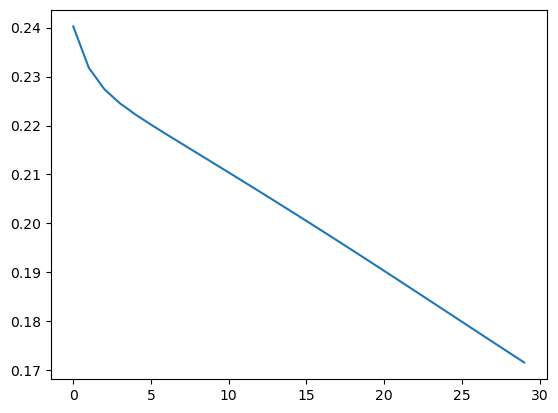

In [25]:
plt.plot(ann.costs)